In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import time
%matplotlib inline

import utils

In [2]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [73]:
print ("Started!!")

st = time.time()
start_date="2011-04-01"
end_date="2016-04-01"
input_data, input_list = utils.get_fixed_data(input_list[:10], start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
('fail_name_list: ', [])
time for getting data: 71.0388810635


In [4]:
input_value = input_data.values
index = input_data.index
input_tilde = pd.DataFrame(input_value[:, :10], index=index)

In [5]:
print (input_tilde.values.shape)

(2517, 9)


In [74]:
print(input_data.index)

DatetimeIndex(['2011-04-01', '2011-04-04', '2011-04-05', '2011-04-06',
               '2011-04-07', '2011-04-08', '2011-04-11', '2011-04-12',
               '2011-04-13', '2011-04-14',
               ...
               '2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01'],
              dtype='datetime64[ns]', length=1258, freq=None)


# DDPG for trading


Given data, you are going to learn how to manage your portfolio.

index = pd.date_range('23/10/2016', periods=100, freq='D')
value = np.random.normal(0, 1, (len(index), n_stock))
input_tilde = pd.DataFrame(value, index=index)

In [78]:
np.power??

In [245]:
from collections import deque, namedtuple
import numpy as np
from numpy.random import choice

Experiecne = namedtuple('Experience', 'state0,  action, reward, state1')

class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        # self.data = [None for _ in range(maxlen)]
        self.data = []
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx< 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]
    
    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item
            self.data[:-1] = self.data[1:]
        else:
            # This should never happen
            raise RuntimeError()
        self.data.append(v)
        
class SequentialMemory(object):
    def __init__(self, limit=1000):
        self.limit = limit
        self.priority = []
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.observations = RingBuffer(limit)
        self.batch_idx = None
        
    def sample(self, batch_size, window_length, alpha=1.0, beta=1.0, epsilon=0.05):
        # udpate priority when sampling
        if len(self.priority) > self.limit:
            self.priority = self.priority[-self.limit:]
        # draw random indexes such that is bigger than window_length to enough length data
        index_space = np.arange(window_length, self.nb_entries)
        # prioritized sample
        p = np.array(self.priority)[window_length:]
        p_tilde = p + np.ones(self.nb_entries - window_length) * np.mean(p) * epsilon
        p_tilde[-1] = np.mean(p)
        p_tilde = p_tilde ** alpha
        p_tilde = p_tilde / np.sum(p_tilde)
        batch_idx = choice(index_space, p=p_tilde, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries - 1]))
        assert len(batch_idx) == batch_size
        # keep batch_idx to update pritority
        self.batch_idx = batch_idx
        
        # weights to modify biased update
        weights = 1. / (p_tilde**beta)
        weights = weights / np.max(weights)
        ret_w = weights[batch_idx - window_length]
        
        # create experiences
        state0 = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        action = np.array([self.actions[idx - 1] for idx in batch_idx])
        reward = np.array([self.rewards[idx - 1] for idx in batch_idx])
        state1 = np.array([[self.observations[i] for i in range(idx - window_length + 1,idx + 1)] for idx in batch_idx])
        return Experiecne(state0, action, reward, state1), ret_w
    
    def sample_state(self, batch_size, window_length, alpha=0.5, epsilon=0.05):
        # udpate priority when sampling
        if len(self.priority) > self.limit:
            self.priority = self.priority[-self.limit:]
        # draw random indexes such that is bigger than window_length to enough length data
        index_space = np.arange(window_length, self.nb_entries)
        # prioritized sample
        p = np.array(self.priority)[window_length:]
        p_tilde = p + np.ones(self.nb_entries - window_length) * np.mean(p) * epsilon
        p_tilde[-1] = np.mean(p)
        p_tilde = p_tilde ** alpha
        p_tilde = p_tilde / np.sum(p_tilde)
        batch_idx = choice(index_space, p=p_tilde, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries]))
        assert len(batch_idx) == batch_size
        
        # create experiences
        state = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        return state
    
    def update_priority(self,error):
        for idx, i in enumerate(self.batch_idx):
            self.priority[i] = error[idx]
    
    
    def append(self, observation, action, reward):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        # initialize new sample with 1
        self.priority.append(1.0)
    
    @property
    def nb_entries(self):
        return  len(self.observations)

In [285]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import time

# from memory import SequentialMemory

class DDPG(object):
    """Deep Deterministic Poilicy Gradient
    
    Basend on DPG and Multiscale CNN, seek out 
    optimal strategy for stock trading.
    
    Available function
    - build_model: build network basedon tensorflow and keras
    - train: given DateFrame stock data, train network
    """
    
    def __init__(self, config):
        """initialized approximate value function
        
        config should have the following attributes
        
        Args:
            gamma(float): the decay rate for value at RL
            history_length(int): input_length for each scale at CNN
            n_feature(int): the number of type of input 
                (e.g. the number of company to use at stock trading)
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): the nubmer of history that will be used as input
            n_smooth, n_down(int): the number of smoothed and down sampling input at CNN
            k_w(int): the size of filter at CNN
            n_hidden(int): the size of fully connected layer
            n_batch(int): the size of mini batch
            n_epochs(int): the training epoch for each time
            update_rate (0, 1): parameter for soft update
            learning_rate(float): learning rate for SGD
        """
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_feature = config.n_feature
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.update_rate = config.update_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.lr = config.learning_rate
        # the actual dimention of input
        # self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        # self.sess = tf.Session()
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
    
    def train(self, input_data, n_memory=1000, noise_scale=0.1):
        """training DDPG, where action is confined to integer space
        
        Args:
            data (DataFrame): stock price for self.n_feature companies
        """
        stock_data = input_data.values
        date = input_data.index
        T = len(stock_data)
        
        # frequency for output
        print_freq = int(T / 100)
        if print_freq == 0:
            print_freq = 1
            
        print_freq = 1
            
        print ("training....")
        st = time.time()
        # prioritizomg parameter
        alpha = self.alpha
        beta = self.beta
        db = (1 - beta) / 1000
        
        # result for return value
        values = []
        date_label = []
        value = 0
        values.append(value)
        date_label.append(date[0])
        # keep half an year data 
        memory = []
        for i in range(self.n_epochs):
            memory.append(SequentialMemory(n_memory))
        plot_freq = 10
        save_freq = 10
        count = 0
        for t in range(T - 1):
            # until having enough data, just do nothing
            if t <= self.n_history + self.n_batch:
                # action_off = np.round(np.random.normal(0, noise_scale, self.n_stock))
                for i in range(self.n_epochs):
                    action_off = np.random.normal(0, 10, self.n_stock)
                    reward = np.sum((stock_data[t + 1] - stock_data[t]) * action_off)
                    memory[i].append(stock_data[t], action_off, reward)
                continue
            price = stock_data[t]
            future_price = stock_data[t + 1]
            for i in range(self.n_epochs):
                memory[i].observations.append(price)
                memory[i].priority.append(1.0)
            # to stabilize batch normalization, use other samples for prediction
            pred_state = memory[0].sample_state(self.n_batch, self.n_history)
            # off policy action and update portfolio
            actor_action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
            # action_off = np.round(actor_value_off + np.random.normal(0, noise_scale, self.n_stock))
            var = np.mean(actor_action ** 2)
            for i in range(self.n_epochs):
                action_off = actor_action + np.random.normal(0, np.sqrt(var) * noise_scale, self.n_stock)
                # action_off = actor_value_off
                reward_off = reward = np.sum((future_price - price) * action_off)
                memory[i].rewards.append(reward_off)
                memory[i].actions.append(action_off)
            # on policy action and update portfolio
            # action_on = np.round(actor_value_on)
            action_on = actor_action
            reward_on = np.sum((future_price - price) * action_on)
            value += reward_on
            date_label.append(date[t+1])
            values.append(value)
            # experiences_test = memory.sample(self.n_batch, self.n_history)
            # update network
            critic_value = self.sess.run(self.Q_actor,
                                      feed_dict={self.state: pred_state,
                                                K.learning_phase(): 0})[-1]
            count += 1
            for epoch in range(self.n_epochs):    
                # select transition from pool
                experiences, weights = memory[epoch].sample(self.n_batch, self.n_history, alpha, beta)
                self.sess.run(self.critic_optim, 
                              feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         self.weights: weights,
                                         self.learning_rate: self.lr,
                                         K.learning_phase(): 1})  
                self.sess.run(self.actor_optim,
                                       feed_dict={self.state: experiences.state0,
                                                            self.learning_rate: self.lr,
                                                            K.learning_phase(): 1})  
                
                error = self.sess.run(self.error,
                                      feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         K.learning_phase(): 0})
                memory[epoch].update_priority(error)
                
                loss = self.sess.run(self.loss, feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         self.weights: weights,
                                         K.learning_phase(): 1})
                
                target_value = self.sess.run(self.target_value, feed_dict={
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         K.learning_phase(): 1})
                # print('critic_value', critic_value)
                
                
                # print('target:', np.mean(target_value))
                # print('Q_value:', np.mean(target_value - experiences.reward))
                # print('reward:', np.mean(experiences.reward))
                    
                # softupdate for critic network
                old_weights = self.critic_target.get_weights()
                new_weights = self.critic.get_weights()
                weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w for new_w, old_w in zip(new_weights, old_weights)]
                self.critic_target.set_weights(weights)
                
                # softupdate for actor network
                """
                old_weights = self.actor_target.get_weights()
                new_weights = self.actor.get_weights()
                weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w for new_w, old_w in zip(new_weights, old_weights)]
                self.actor_target.set_weights(weights)
                """
                
                # update prioritizing paramter untill it goes over 1
                beta  += db
                if beta >= 1.0:
                    beta = 1.0
                 
            if t % print_freq == 0:
                print ("time:",  date[t + 1])
                print("reward:", reward_on)
                print('critic_value', critic_value)
                print("value:", value)
                print("portfolio:", action_on)
                # print('batch_idx:', memory.batch_idx)
                print('priority:', np.mean(memory[0].priority))
                # print('loss:', loss)
                print ("elapsed time", time.time() - st)
                print("********************************************************************")
                
            if count % plot_freq == 0:
                result = pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
                result.to_csv("trading_result_{}.csv".format(date[t + 1]))
                # plt.plot(result)
                
            if count % save_freq == 0:
                save_path = self.saver.save(self.sess, self.save_path)
                print("Model saved in file: %s" % save_path)

        print ("finished training")
           
        return pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        # self.actor_target = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        input_q = [raw,] +  smoothed + down + [self.action,]
        self.Q = tf.squeeze(self.critic(input_q))
        # target network
        # for double q-learning we use actor network not for target network
        self.actor_target_output = self.actor([raw_target,] +  smoothed_target + down_target)
        input_q_target = [raw_target,] +  smoothed_target + down_target + [self.actor_target_output,]
        Q_target = tf.squeeze(self.critic_target(input_q_target))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        self.target_value = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        # get rid of bias of prioritized
        self.weights = tf.placeholder(tf.float32, shape=[None], name="weights")
        self.loss = tf.reduce_mean(self.weights * tf.square(target - self.Q), name='loss')
        # TD-error for priority
        self.error = tf.abs(target - self.Q)
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor([raw,] +  smoothed + down)
        input_q_actor = [raw,] +  smoothed + down + [self.actor_output,]
        self.Q_actor = tf.squeeze(self.critic(input_q_actor))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        self.saver = tf.train.Saver()
        is_initialize = True
        if self.is_load:
            if self.load(self.save_path):
                print('succeded to load')
                is_initialize = False
            else:
                print('failed to load')
        
        # initialize network
        if is_initialize:
            tf.initialize_all_variables().run(session=self.sess)
            weights = self.critic.get_weights()
            self.critic_target.set_weights(weights)
            # weights = self.actor.get_weights()
            # self.actor_target.set_weights(weights)
        
    def build_critic(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth)]
        for m in sm_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down)]
        for m in dw_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        nf = self.n_feature
        state.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
        # state.add(SpatialDropout2D(0.2))
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        merged_state = Sequential()
        merged_state.add(merged)
        # merged_state.add(SpatialDropout2D(0.2))
        merged_state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        merged_state.add(BatchNormalization(mode=2, axis=-1))
        merged_state.add(PReLU())
        merged_state.add(Flatten())
        # layer3
        action = Sequential()
        action.add(Lambda(lambda x: x, input_shape=(self.n_stock,)))
        action.add(BatchNormalization(mode=1, axis=-1))
        merged = Merge([merged_state, action], mode='concat')
        model = Sequential()
        model.add(merged)
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.2))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.2))
        model.add(Dense(1))
        return model
    
    def build_actor(self):
        """Build actor network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth)]
        for m in sm_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down )]
        for m in dw_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input     
        state = Sequential()
        state.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
        # state.add(SpatialDropout2D(0.2))
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat')
        # layer2
        nf = nf * 2
        model = Sequential()
        model.add(merged)
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        model.add(BatchNormalization(mode=2 , axis=-1))
        model.add(PReLU())
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_hidden))
        # model.add(BatchNormalization(mode=1, axis=-1))}
        model.add(PReLU())
        # output
        model.add(Dense(self.n_stock))
        return model
    
    def transform_input(self, input):
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :] for st in range(n_sm)]),0)
            )
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down
    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False


In [ ]:
# import numpy as np 
# input_data = np.zeros((505, 99))
n_stock = len(input_tilde.values[0])
# n_stock = 10

class MultiDDPGConfig(object):
    device = '/gpu:0'
    save_path = '/home/tomoaki/work/github/DQN/DDPG_model.ckpt'
    is_load = False
    activation = 'relu'
    gamma = 0.99
    history_length = 10
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 100
    n_feature = 32
    alpha = 0.7
    beta = 0.5
    update_rate = 1e-2
    learning_rate = 1e-3

In [ ]:
# from model import DDPG
import warnings
warnings.filterwarnings("ignore")

config = MultiDDPGConfig()

dqn = DDPG(config)
print ("start!")
values = dqn.train(input_tilde)
print ("finished!")

building model....
finished building model!
start!
training....
time: 2006-08-16 00:00:00
reward: 1.28894314758
critic_value -0.85361
value: 1.28894314758
portfolio: [-0.22703475  0.99718505  0.00514706 -0.34500262 -0.46659532  0.13846406
  0.2356434  -0.04394062  0.87358785]
priority: 15.0966681724
elapsed time 33.277643919
********************************************************************


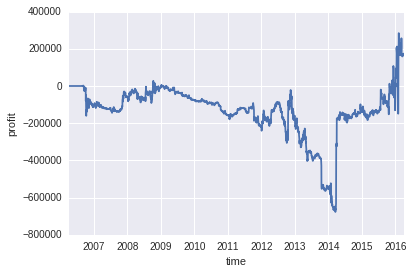

In [278]:
plt.plot(values)
plt.xlabel('time')
plt.ylabel('profit')
plt.savefig('DDPG_trading.jpg')

In [279]:
values.to_csv("trading_result.csv")

In [280]:
data = pd.read_csv("trading_result.csv", index_col=0)

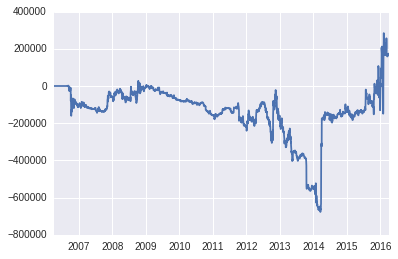

In [281]:
plt.plot(pd.DatetimeIndex(data.index), data.values[:, 0])

In [71]:
data.index

Index([u'2006-04-03', u'2006-08-16', u'2006-08-17', u'2006-08-18',
       u'2006-08-21', u'2006-08-22', u'2006-08-23', u'2006-08-24',
       u'2006-08-25', u'2006-08-28',
       ...
       u'2016-03-18', u'2016-03-21', u'2016-03-22', u'2016-03-23',
       u'2016-03-24', u'2016-03-28', u'2016-03-29', u'2016-03-30',
       u'2016-03-31', u'2016-04-01'],
      dtype='object', length=2424)

In [83]:
np.concatenate(([[1, 2]], [[2, 3]]), axis=-1)

array([[1, 2, 2, 3]])

In [88]:
a = np.random.random_integers(0, 10, 10)
print(1./a ** (2))
print(a)

[ 0.01               inf  0.0625      1.                 inf  0.0625
  0.02040816  0.0625      0.25        1.        ]
[10  0  4  1  0  4  7  4  2  1]


In [81]:
a

array([ 7,  9,  8,  1,  1,  6,  4,  9, 10,  9])